<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/APC_Exercises/set_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The main topic of this problem set is **linear regression** and its variants.

# 1. Rocket motion

Our model tries to describe $s(t)$, where $s$ is the rocket height. Of course, we propose a physics-based model:

$$
y(t) = a + bt + ct^2
$$

At first, this problem seems non-linear. But if we work in the 2D feature space $\{z_1, z_2\}$ where $z_1 = t$ and $z_2 = t^2$, it becomes linear.

Therefore, we shall proceed with a linear regression model. 

We actually work in a 3D feature space, since we shall perform a pre-processing step of appending a constant unit-valued feature to each observation. This trick allow us to incorporate the bias term neatly to our closed-form solution for linear regression.

In [14]:
def gen_dataset():
    dt = 5
    t = np.arange(5, 30+dt, dt)
    s = np.array([722, 1073, 1178, 1177, 781, 102])
    N = t.size
    data = np.array([np.ones(N), t, t**2]).T.reshape(N, 3) # N, D
    labels = s.T
    return data, labels

In [15]:
X, y = gen_dataset()
print(X.shape, y.shape)

(6, 3) (6,)


In [16]:
# Visualize dataset
X_df = pd.DataFrame(X, columns=["bias", "t", "t^2"])
X_df

,bias,t,t^2
0,1.0,5.0,25.0
1,1.0,10.0,100.0
2,1.0,15.0,225.0
3,1.0,20.0,400.0
4,1.0,25.0,625.0
5,1.0,30.0,900.0


In [17]:
def linreg(X, y, lamb=0, return_weights=False):
    XTX = (X.T).dot(X)
    to_invert = (XTX + lamb*np.eye(XTX.shape[0]))
    XTy = (X.T).dot(y)
    w = np.linalg.inv(to_invert).dot(XTy)
    preds = X.dot(w)
    if return_weights:
        return preds, w
    else:
        return preds

In [18]:
# Without regularization
preds, w = linreg(X, y, lamb=0, return_weights=True)

In [19]:
print(w, w.shape)

[ 44.2        156.12428571  -5.11      ] (3,)


Text(0.5, 0, 't')

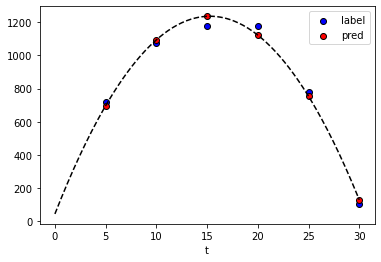

In [20]:
plt.scatter(X[:, 1], y, color="blue",
            marker="o", ec="k", label="label")
plt.scatter(X[:, 1], preds, color="red",
            marker="o", ec="k", label="pred")
t = np.linspace(0, X[:, 1].max(), 200)
plt.plot(t, w[0] + w[1]*t + w[2]*(t**2),
         color="k", ls="--")
plt.legend()
plt.xlabel("t")

In [47]:
# With regularization, lambda=0.5
regularization = 0.5
preds_reg, w_reg = linreg(X, y, lamb=regularization, return_weights=True)

In [48]:
print(w_reg, w_reg.shape)

[ 28.81692798 157.42734984  -5.13590407] (3,)


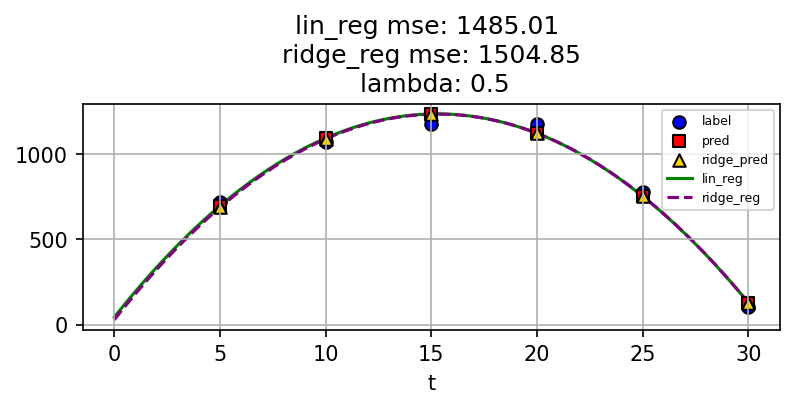

In [49]:
plt.figure(figsize=(6, 2), dpi=150)

plt.scatter(X[:, 1], y, color="blue",
            marker="o", ec="k", label="label")
            
plt.scatter(X[:, 1], preds, color="red",
            marker="s", ec="k", label="pred")

plt.scatter(X[:, 1], preds_reg, color="gold",
            marker="^", ec="k", label="ridge_pred")

t = np.linspace(0, X[:, 1].max(), 200)

plt.plot(t, w[0] + w[1]*t + w[2]*(t**2),
         color="green", ls="-", label="lin_reg", zorder=-5)

plt.plot(t, w_reg[0] + w_reg[1]*t + w_reg[2]*(t**2),
         color="purple", ls="--", label="ridge_reg", zorder=-5)


mse = ((y - preds)**2).mean()
mse_reg = ((y - preds_reg)**2).mean()

plt.legend(fontsize=6)
plt.xlabel("t")
description = f"lin_reg mse: {mse:.2f} \n ridge_reg mse: {mse_reg:.2f} \n lambda: {regularization}"
plt.title(description)
plt.grid()

In [50]:
w_df = pd.DataFrame(np.array([w, w_reg]).T, columns=["default", "regularized"])
w_df

,default,regularized
0,44.200000,28.816928
1,156.124286,157.427350
2,-5.110000,-5.135904


Let's use some randomly generated synthetic data and try to perform high-degree fitting.

In [280]:
def gen_dataset_synthetic(degs=50, tmax=50):
    dt = 0.5
    t = np.arange(0, tmax, dt)
    N = t.size
    s = 10 + 0.5*t + 20*np.sin(10/50 * t)
    rng = np.random.default_rng(seed=42)
    noise = 4*rng.normal(0, 1, size=N)
    s += noise
    
    data = np.array(np.ones(N))
    for deg in range(1, degs):
        data_col = np.array(t**deg)
        data = np.vstack((data, data_col))
    data = data.T # N, D
    labels = s.T
    return data, labels

In [281]:
def svd_reg(X, y, lamb=0, svd=True):
    XTX = (X.T).dot(X)
    to_invert = (XTX + lamb*np.eye(XTX.shape[0]))
    to_svd = np.linalg.inv(to_invert).dot(X.T)
    w = to_svd.dot(y)
    preds = X.dot(w)
    if svd:
        return w, preds, to_svd
    else:
        return w, preds

In [282]:
X, y = gen_dataset_synthetic(degs=10)
print(X.shape)

(100, 10)


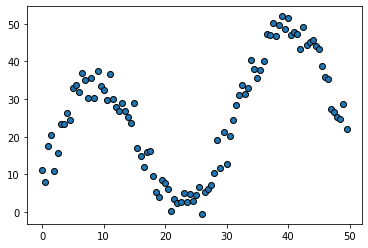

In [283]:
plt.scatter(X[:, 1], y, ec="k")

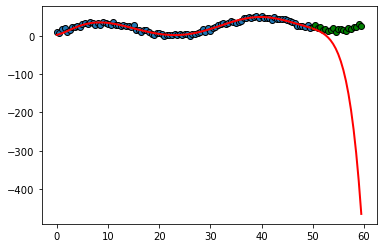

In [293]:
w, p, U = svd_reg(X, y, lamb=10)
_ = plt.scatter(X[:, 1], y, ec="k")
_ = plt.plot(X[:, 1], p, ls="-", color="red", lw=2.0)

X2, y2 = gen_dataset_synthetic(degs=10, tmax=60)
_ = plt.scatter(X2[X[:, 1].size:, 1], y2[X[:, 1].size:], ec="k", color="g")
new_preds = X2.dot(w)
_ = plt.plot(X2[X[:, 1].size:, 1], new_preds[X[:, 1].size:], ls="-", color="red", lw=2.0)

We can see how poorly the model generalizes! It heavily overfits the training data. This is what usually happens with high degree polynomial fitting, since it approximates well inside interpolation interval, but diverge rapidly outside.

In [326]:
def gen_dataset_synthetic2(freqs=50, tmax=50):
    dt = 0.01
    t = np.arange(0, tmax, dt)
    N = t.size
    s = 10 + 0.5*t + 20*np.sin(10/50 * t)
    rng = np.random.default_rng(seed=42)
    noise = 4*rng.normal(0, 1, size=N)
    s += noise
    
    data = np.array(np.ones(N))
    data_col = np.array(t)
    data = np.vstack((data, data_col))
    for deg in range(1, freqs):
        data_col = np.array(np.sin(freqs*t))
        data = np.vstack((data, data_col))
        data_col = np.array(np.cos(freqs*t))
        data = np.vstack((data, data_col))
    data = data.T # N, D
    labels = s.T
    return data, labels

In [344]:
X, y = gen_dataset_synthetic(degs=5)
print(X.shape)

(100, 5)


Text(0.5, 1.0, 'best lambda: 0.00')

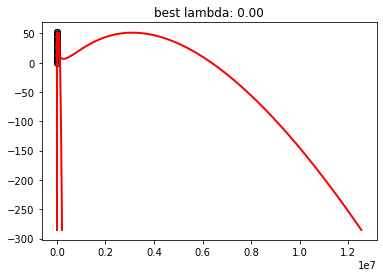

In [345]:
Ntrials = 100
mse_history = np.zeros(Ntrials)
lambspace = np.logspace(-5, 5, Ntrials)
X2, y2 = gen_dataset_synthetic(degs=5, tmax=60)
diff = X2[:, 1].size - X[:, 1].size
for i, lamb in enumerate(lambspace):
    p, w = linreg(X, y, lamb=10, return_weights=True)
    new_preds = X2[diff:].dot(w)
    mse = ((y2[diff:] - new_preds)**2).mean()
    mse_history[i] = mse

best_lamb = lambspace[np.argmin(mse_history)]
p, w = linreg(X, y, lamb=best_lamb, return_weights=True)
new_preds = X2[diff:].dot(w)


_ = plt.scatter(X[:, 1], y, ec="k")
_ = plt.plot(X[:, 1], p, ls="-", color="red", lw=2.0)
_ = plt.scatter(X2[X[:, 1].size:, 1], y2[X[:, 1].size:], ec="k", color="g")
_ = plt.plot(X2[diff:], new_preds, ls="-", color="red", lw=2.0)
plt.title(f"best lambda: {best_lamb:.2f}")